# 6.S083 / 18.S190 Spring 2020: Problem set 4

Submission deadline: Tuesday April 28, 2020 at 11:59pm.


In this problem set, we will look at the simplest epidemic model in which
we take **space** into account.

The simplest way to do this is to use **discrete space**: each agent lives
in a cell of a square grid. For simplicity in the coding we will not allow more
than one agent in any one grid cell, but this means that we need to carefully
design the rules of the model to respect this.

The effect of space is thus to *restrict* the set of other agents with which
a given agent can interact at any one time. (Compare the previous Problem Set,
in which any agent could interact with any other.)




## Exercise 1: Moving in 2D

In this exercise we will implement a random walk on a 2D lattice (grid).



1. Define an abstract type `AbstractWalker`.

In [39]:
abstract type AbstractWalker end

2. Define an abstract type `Abstract2DWalker` that is a subtype of `AbstractWalker` (using  `<:`).



In [3]:
abstract type Abstract2DWalker <: AbstractWalker end

3. Define an immutable type `Location` that contains integers `x` and `y`.



In [4]:
struct Location
    x::Int
    y::Int
end

4. Define a `mutable` `Walker2D` type that is a subtype of `AbstractWalker2D`. It should contain a field `position` that is a `Location` object.



In [5]:
mutable struct Walker2D <: Abstract2DWalker
    position::Location
end

5. Check that Julia automatically provides a constructor function `Walker2D(position)` that accepts an object of type `Location`.

    Construct a `Walker` located at the origin.



In [6]:
methods(Walker2D)

# 2 methods for type constructor:
[1] Walker2D(position::Location) in Main at In[5]:2
[2] Walker2D(position) in Main at In[5]:2

In [7]:
origin = Walker2D(Location(0, 0))

Walker2D(Location(0, 0))

6. Write a new method of the constructor for `Walker2D` that accepts two integers, $x$ and $y$, i.e. `Walker2D(x, y)`.



In [8]:
Walker2D(x, y) = Walker2D(Location(x, y))

Walker2D

7. Write a function `make_tuple` that takes an object of type `Location` and returns the corresponding tuple
`(x, y)`.

In the following questions, the functions should take an object of type `AbstractWalker2D`
(or you can just leave them untyped).



In [9]:
make_tuple(loc) = (loc.x, loc.y)

make_tuple (generic function with 1 method)

8. Write a getter function `pos` that returns the position as a `Location` object.



In [10]:
pos(walker) = (walker_location = walker.position; Location(walker_location.x, walker_location.y))

pos (generic function with 1 method)

9. Write a setter function `set_pos!` that sets the position to a given location `l`.



In [11]:
set_pos!(walker, l::Location) = walker.position = l

set_pos! (generic function with 1 method)

10. Write a function `jump` that returns a possible new position for a walker after a 2D jump
as a `Location` object. This function should *not* modify its argument,
and hence does not have a `!` in its name.

    Jumps are equally likely in the directions right, up, left and down.

    A nice way to implement this is to make a tuple `neighbours` of possible
    destinations.



In [12]:
function jump(walker)
    ∇x, ∇y = rand(((0, 1), (0, -1), (-1, 0), (1, 0)))
    
    x, y = make_tuple(pos(walker))
    
    Location(x + ∇x, y + ∇y)
end

jump (generic function with 1 method)

11. Write a function `jump!` that moves a walker to a new position. What arguments does the function need? Use your `jump` function to write `jump!`.



In [13]:
jump!(walker) = set_pos!(walker, jump(walker))

jump! (generic function with 1 method)

12. Write a function `trajectory` that calculates a trajectory of a 2D ∈ker of length $N$.



In [14]:
trajectory(n, walker = Walker2D(0, 0)) = [make_tuple(jump!(walker)) for _ ∈ 1:n]

trajectory (generic function with 2 methods)

13. Plot 10 t∈ectories of length 10,000 on a single figure, all starting at the origin.

    Note that `Plots.jl` can accept a `Vector` of `Tuple`s, i.e. $(x, y)$ pairs, as the coordinates to plot.

In [15]:
using Plots; plot();

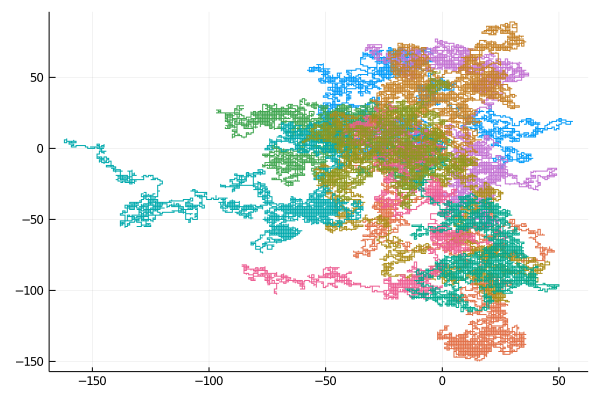

In [16]:
plot(legend=false)
for _ ∈ 1:10
    trajectory(10_000) |> plot!
end
plot!()

## Exercise 2: Making agents move

In this exercise we will combine our `Agent` type from Problem Set 3 with the 2D random walker that we just created, by adding a position to the `Agent` type.



1. Define a mutable type `Agent` that is a subtype of `AbstractWalker2D` from Exercise 1, since it will behave like a random walker and lives in 2D.

    `Agent` should contain a `position` of type `Location`, as well as a `state` of type `InfectionStatus`.

    (For simplicity we will not require a `num_infected` field, but feel free to do so if you would like.)




In [17]:
 @enum InfectionStatus S I R

In [18]:
mutable struct Agent <: AbstractWalker
    position::Location
    state::InfectionStatus
    num_infected::Int
end

In [19]:
Agent(x, y) = Agent(Location(x, y), S, 0)

Agent

2. Agents live in a box of side length `L`, centered at the origin. We need to decide (i.e. model) what happens when they reach the walls of the box (boundaries), i.e. what kind of **boundary conditions** to use.

    One type of boundary condition that is relatively simple to implement are **reflecting boundary conditions**, as follows:

    Each side of the box is a reflective mirror. We can model this using "bounce-back": if the particle tries to jump beyond one of the boundaries, it hits a springy wall and bounces back to the *same* position that it started from. That is, it **proposes** to take a step, but "realises" that it is blocked in that direction, so just stays where it is instead for that step.


    Use the `jump` function from before (that proposes a new position) inside a new
    method of the `jump` function for an `Agent` that also accepts a size `L`
    and implements reflecting boundary conditions.
    It returns a `Location` object representing the new position (inside the grid).



In [20]:
function jump(walker, L)
    ∇x, ∇y = rand(((0, 1), (0, -1), (-1, 0), (1, 0)))
    
    walker_position = pos(walker)
    x, y = make_tuple(walker_position)
    
    x₊, y₊ = x + ∇x, y + ∇y
    
    (abs(x₊) <= L && abs(y₊) <= L) ? Location(x₊, y₊) : walker_position
end

jump (generic function with 2 methods)

3. Check that this is working by drawing a trajectory of an `Agent` inside a square box of side length 20,
using your function `trajectory` from Exercise 1.

    You should draw the boundaries of the box and also a trajectory that is sufficiently long to see what happens at the boundary, but not so long that it fills up the box.

In [21]:
jump!(walker, L) = set_pos!(walker, jump(walker, L))
trajectory(n, L, walker = Walker2D(0, 0)) = [make_tuple(jump!(walker, L)) for _ ∈ 1:n]

trajectory (generic function with 3 methods)

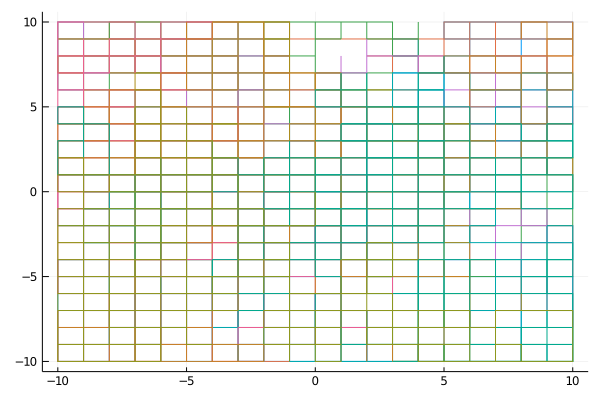

In [22]:
plot(legend=false)
for _ ∈ 1:10
    trajectory(1_000, 10) |> plot!
end
plot!()

### Exercise 3: Spatial epidemic model  -- Initialization and visualization

We now have all of the technology in place to simulate an agent-based model in space!

For simplicity we will impose in the model that there is at most one agent on each site at all times, modelling the fact that two people cannot be in the same place as each other.

We thus begin by creating an initial condition for $N$ agents that satisfies this. Later we must make sure that the dynamics also respects this.



1. Write a function `initialize` that takes parameters $L$, the side length of the square box where the agents live, and $N$, the number of agents.

    It should build, one by one, a collection of agents, by proposing a position for each one and checking if that position is occupied. If the position is occupied, it should generate another one, and so on until it finds a free spot.

    You may create additional functions to help with this if you find it useful to do so.

    The agents should all have initial status `S`, except for one of them, e.g. the first in the list, which has initial status `I` -- i.e. it is the only source of infection.

    It should return the `Vector` of `Agent`s.



In [23]:
function find_unoccupied_location(occupied)
    L = size(occupied, 1)
    mid = L ÷ 2
    
    x, y = rand(-mid:mid), rand(-mid:mid)
    while get_value_at_loc(occupied, (x, y))
        x, y = rand(-mid:mid), rand(-mid:mid)
    end
    
    x, y
end

function get_loc(field, (x, y))
    L = size(field, 1)
    mid = L ÷ 2
    
    x += mid + 1
    y += mid + 1
    
    x, y
end

get_value_at_loc(field, (x, y)) = field[get_loc(field, (x, y))...]

set_value_at_loc!(field, (x, y), val) = field[get_loc(field, (x, y))...] = val

function initialize(L, N)
    L = isodd(L) ? L : L+1
    @assert N <= L^2
    
    occupied = falses(L, L)
    agents = [Agent(Location(0, 0), I, 0)]
    set_value_at_loc!(occupied, (0, 0), true)
    
    for _ ∈ 1:N-1
        x, y = find_unoccupied_location(occupied)
        
        push!(agents, Agent(x, y))
        set_value_at_loc!(occupied, (x, y), true)
    end
    
    agents
end

initialize (generic function with 1 method)

2. Run your initialization function for $L=10$ and $N=20$.



In [24]:
agents = initialize(10, 20)

20-element Array{Agent,1}:
 Agent(Location(0, 0), I, 0)
 Agent(Location(5, 3), S, 0)
 Agent(Location(-5, -1), S, 0)
 Agent(Location(0, 2), S, 0)
 Agent(Location(5, 1), S, 0)
 Agent(Location(5, -5), S, 0)
 Agent(Location(5, -1), S, 0)
 Agent(Location(4, -5), S, 0)
 Agent(Location(1, 1), S, 0)
 Agent(Location(-5, -5), S, 0)
 Agent(Location(-5, 0), S, 0)
 Agent(Location(-2, -3), S, 0)
 Agent(Location(-2, 5), S, 0)
 Agent(Location(2, 0), S, 0)
 Agent(Location(4, -1), S, 0)
 Agent(Location(1, -3), S, 0)
 Agent(Location(-4, -4), S, 0)
 Agent(Location(-1, 2), S, 0)
 Agent(Location(-2, 1), S, 0)
 Agent(Location(3, 0), S, 0)

3. Write a function `visualize_agents` that takes in a collection of agents as argument. It should plot a point for each agent, coloured according to its status.

    You can use the keyword argument `c=cs` inside your call to the plotting function to set the colours of points to a vector of integers called `cs`. Don't forget to use `ratio=1`.



In [25]:
function visualize_agents(agents, L)
    L = isodd(L) ? L : L+1
    mid = L ÷ 2
    plot(ratio=1, legend = false)
    
    for agent ∈ agents
        agent_loc = agent |> pos |> make_tuple
        agent_color = agent.state == S ? "blue" : (agent.state == I ? "red" : "green")
        scatter!(agent_loc, c=agent_color)
    end
    
    hline!([-mid, mid])
    vline!([-mid, mid])
    plot!()
end

visualize_agents (generic function with 1 method)

4. Run the function to visualize the initial condition you created.

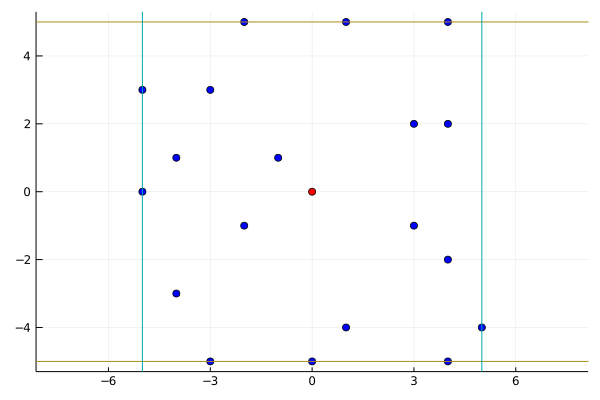

In [26]:
visualize_agents(initialize(10, 20), 11)

### Exercise 4: Spatial epidemic model -- Dynamics



1. Write a function `step!` that does one step of the dynamics of the model.
It takes as parameters $agents$, $L$, $p_I$ and $p_R$.
This combines what we did in the last Problem Set with the 2D random walker above.

    The rules are as follows:

    - A single agent is chosen at random; call it agent $i$.

    - A new position is proposed for that agent.

    - If that new position is not occupied, the agent moves there.

    - If the new position *is* occupied, by agent $j$, then *neither* of them move, but they interact
    via the following rule:

    - If agent $i$ is infected and agent $j$ is susceptible then agent $j$ becomes infected with probability $p_I$.

    - If  agent $i$ is infected, it recovers with probability $p_R$.



In [27]:
function interact!(agentᵢ, agentⱼ, pᵢ, pᵣ)
    if agentᵢ.state == I
        if agentⱼ.state == S && rand() <= pᵢ
            agentⱼ.state = I
            agentᵢ.num_infected += 1
        end
        if rand() <= pᵣ
            agentᵢ.state = R
        end
    end
end

function step!(agents, L, pᵢ, pᵣ)
    L = isodd(L) ? L : L+1
    N = length(agents)
    mid = div(L, 2, RoundDown)
    
    agentᵢ = rand(agents)
    new_pos = jump(agentᵢ, mid)
    new_pos_occupied_by = findfirst(walker->walker.position == new_pos, agents)
        
    if new_pos_occupied_by === nothing
        set_pos!(agentᵢ, new_pos)
    else
        agentⱼ = agents[new_pos_occupied_by]
        interact!(agentᵢ, agentⱼ, pᵢ, pᵣ)
    end
end

step! (generic function with 1 method)

2. Make a small system and run the `step!` function a few times to check (by eye) that it's doing the right thing.



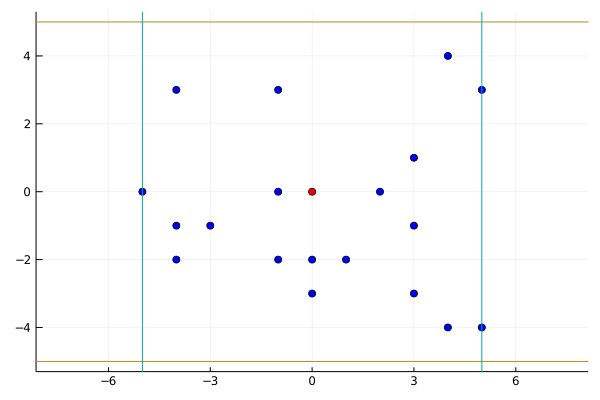

In [28]:
agents = initialize(10, 20)
visualize_agents(agents, 10)

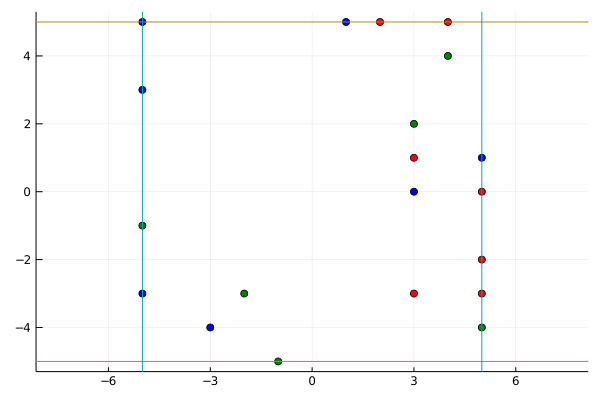

In [29]:
for _ ∈ 1:1000
    step!(agents, 11, .7, .1)
end
visualize_agents(agents, 11)

3. Make an interactive visualization to display the agents after each step, to again check visually that the implementation is correct.



In [30]:
using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-10708225275593557601\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12423917688734722554\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-10708225275593557601\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [31]:
L, N, T = 10, 90, 1_000
pᵢ, pᵣ = .5, .01
agents = initialize(L, N)
agents_at_t = [deepcopy(agents)]
for t ∈ 1:T
    step!(agents, L, pᵢ, pᵣ)
    push!(agents_at_t, deepcopy(agents))
end

@manipulate for t ∈ 1:T
    visualize_agents(agents_at_t[t+1], L)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["t"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 1000,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
500, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\akshu\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\akshu\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\akshu\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\akshu\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\akshu\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000017627990, Task (runnable) @0x0000000017627990), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\

4. Write a function `sweep!` that takes the relevant parameters and performs one sweep, i.e. $N$ steps.



In [32]:
function sweep!(agents, L, pᵢ, pᵣ)
    N = size(agents, 1)
    for _ in 1:N
        step!(agents, L, pᵢ, pᵣ)
    end
end

sweep! (generic function with 1 method)

5. Write a function `dynamics!` that takes the same parameters as `step!`, together with a number of sweeps.

    Run the dynamics for the given number of sweeps.

    Save the state of the whole system, together with the total numbers of $S$, $I$ and $R$ individuals, after each sweep, for later use.

    You may need the function `deepcopy` to copy the state of the whole system.



In [33]:
function count_statuses(agents)
    Scount = Icount = Rcount = 0
    
    for agent ∈ agents
        agent.state == S && (Scount += 1)
        agent.state == I && (Icount += 1)
        agent.state == R && (Rcount += 1)
    end
    
    Scount, Icount, Rcount
end

function dynamics!(agents, L, pᵢ, pᵣ, num_sweeps)
    agents_at_t = [deepcopy(agents)]
    Ss, Is, Rs = Int[], Int[], Int[]
    
    for _ ∈ 1:num_sweeps
        sweep!(agents, L, pᵢ, pᵣ)
        push!(agents_at_t, deepcopy(agents))
        Scount, Icount, Rcount = count_statuses(agents)
        push!(Ss, Scount)
        push!(Is, Icount)
        push!(Rs, Rcount)
    end
    popfirst!(agents_at_t)
    
    agents_at_t, Ss, Is, Rs
end

dynamics! (generic function with 1 method)

6. Given one simulation run, write an interactive visualization that shows both the state at time $n$ (using `visualize_agents`) and the history of $S$, $I$ and $R$ from time $0$ up to time $n$. To do this, make two separate plot objects $p_1$ and $p_2$ and use the $hbox$ or $vbox$ function to put them together horizontally or vertically into a single plot.



In [34]:
L, N, T = 20, 300, 1_000
pᵢ, pᵣ = .5, .01
agents = initialize(L, N)
agents_at_t, Ss, Is, Rs = dynamics!(agents, L, pᵢ, pᵣ, T);
M = [[i, Ss[i], Is[i], Rs[i]] for i ∈ eachindex(Ss)]

@manipulate for step in 1:T
    p1 = visualize_agents(agents_at_t[step], L)
    p2 = plot(ylabel = "number in state", xlabel = "sweeps x 10")
    plot!(p2,Ss[1:10:step],label="Ss")
    plot!(p2,Is[1:10:step],label="Is")
    plot!(p2,Rs[1:10:step],label="Rs")
    hbox(p1,p2)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["step"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 1000,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
500, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\akshu\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\akshu\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\akshu\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\akshu\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\akshu\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000014118010, Task (runnable) @0x0000000014118010), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"

7. Using $L=20$ and $N=100$, experiment with $p_I$ and $p_R$ until you find an epidemic outbreak. (Take $p_R$ quite small.)

8. For the values of $p_I$ and $p_R$ that you found in [7],
run 50 simulations. Plot $S$, $I$ and $R$ as a function of time for each of them (with transparency!).



In [35]:
using Statistics

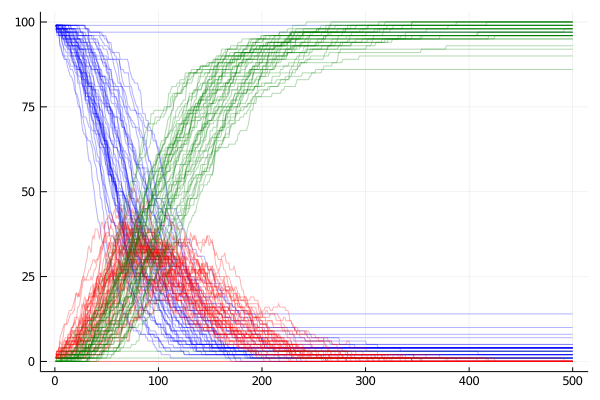

In [36]:
L, N, T = 20, 100, 500
experiment_run = 50
pᵢ, pᵣ = .8, .1
Ssₛ , Iiₛ, Rrₛ = typeof(Ss)[], typeof(Is)[], typeof(Rs)[]

for run in 1:experiment_run
    agents = initialize(L, N)
    agents_at_t, Ss, Is, Rs = dynamics!(agents, L, pᵢ, pᵣ, T)
    push!(Ssₛ, Ss)
    push!(Iiₛ, Is)
    push!(Rrₛ, Rs)
end

plot()
plot!.(Ssₛ, color="blue", alpha=.3, label=false)
plot!.(Iiₛ, color="red", alpha=.3, label=false)
plot!.(Rrₛ, color="green", alpha=.3, label=false)
plot!()

9. Plot their means with error bars.

    You should see a result that looks like all those plots that you've seen of the
    SIR model on the internet. (If you haven't seen any, then what are you waiting for --
    go and find some!)
    Except that they *never show you error bars*, even though error bars are clearly
    *of the utmost importance*.

In [38]:
mean_S = mean(Ssₛ)
sigma_S = std(Ssₛ)

mean_I = mean(Iiₛ)
sigma_I = std(Iiₛ)

mean_R = mean(Rrₛ)
sigma_R = std(Rrₛ);

@manipulate for t in 1:T
    p2 = plot(ylabel = "number in state", xlabel = "sweeps x 5")
    p1 = plot(ylabel = "number in state", xlabel = "sweeps x 5")
    plot!(p2,mean_S[1:5:t],label="Ss",yerr=sigma_S[1:5:t],alpha = .3)
    plot!(p2,mean_S[1:5:t],label="Ss")
    plot!(p2,mean_I[1:5:t],label="Is",yerr=sigma_I[1:5:t],alpha = .3)
    plot!(p2,mean_I[1:5:t],label="Is")
    plot!(p2,mean_R[1:5:t],label="Rs",yerr=sigma_R[1:5:t],alpha = .3)
    plot!(p2,mean_R[1:5:t],label="Rs")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["t"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 500,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
250, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\akshu\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\akshu\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\akshu\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\akshu\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\akshu\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000013d508b0, Task (runnable) @0x0000000013d508b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\"

### Exercise 5 (Extra credit -- or for summer vacation): Social distancing

We can use a variant of the above model to investigate the effect of the
totally mis-named "social distancing"  
(we want people to be socially *close*, but *physically* distant).

In this variant, we separate out the two effects "infection" and
"movement": an infected agent chooses a
neighbouring site, and if it finds a susceptible there then it infects it
with probability $p_I$.

Separately, an agent chooses a neighbouring site to move to,
moves there with probability $p_M$ if the site is not vacant. (Otherwise it
stays where it is.)



In [73]:
function step!(agents, L, pᵢ, pᵣ, pₘ)
    L = isodd(L) ? L : L+1
    N = length(agents)
    mid = div(L, 2, RoundDown)
    
    agentᵢ = rand(agents)
    if !(rand() <= pₘ)
        if agentᵢ.state == I && rand() < pᵣ
            agentᵢ.state = R
        end
        return
    end
    new_pos = jump(agentᵢ, mid)
    new_pos_occupied_by = findfirst(walker->walker.position == new_pos, agents)
        
    if new_pos_occupied_by === nothing
        set_pos!(agentᵢ, new_pos)
    else
        agentⱼ = agents[new_pos_occupied_by]
        interact!(agentᵢ, agentⱼ, pᵢ, pᵣ)
    end
end

function sweep!(agents, L, pᵢ, pᵣ, pₘ)
    for _ in eachindex(agents)
        step!(agents, L, pᵢ, pᵣ, pₘ)
    end
end

function dynamics!(agents, L, pᵢ, pᵣ, pₘ, num_sweeps)
    agents_at_t = typeof(agents)[]
    Ss, Is, Rs = Int[], Int[], Int[]
    
    for _ ∈ 1:num_sweeps
        sweep!(agents, L, pᵢ, pᵣ, pₘ)
        push!(agents_at_t, deepcopy(agents))
        Scount, Icount, Rcount = count_statuses(agents)
        push!(Ss, Scount)
        push!(Is, Icount)
        push!(Rs, Rcount)
    end
    
    agents_at_t, Ss, Is, Rs
end

dynamics! (generic function with 2 methods)

1. When $p_M = 0$, the agents cannot move, and hence are
completely quarantined in their original locations.
Where can the disease spread in this case?

    Run the dynamics repeatedly, looking at which sites become infected.
    (Draw them!)

    How does this change as you increase the *density*
    $\rho = N / (L^2)$ of agents?  Start with a small density.

    This is basically the [**site percolation**](https://en.wikipedia.org/wiki/Percolation_theory)
    model.



In [81]:
L, N, T = 20, 420, 500
@show ρ = N/L^2
p_i, p_r, p_m = .8, .1, .8

agents = initialize(L,N)
states, Ss, Is, Rs = dynamics!(agents, L, p_i, p_r, p_m, T)

@manipulate for step in 1:T
    p1 = visualize_agents(states[step], L)
    p2 = plot(ylabel = "number in state", xlabel = "sweeps x 10")
    plot!(p2,Ss[1:10:step],label="Ss")
    plot!(p2,Is[1:10:step],label="Is")
    plot!(p2,Rs[1:10:step],label="Rs")
    hbox(p1,p2)
end

ρ = N / L ^ 2 = 1.05


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["step"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 500,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
250, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\akshu\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\akshu\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\akshu\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\akshu\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\akshu\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000000141bfc70, Task (runnable) @0x00000000141bfc70), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"2

2. When we start to increase $p_M$, we allow some local motion via random walk.
Investigate how this leaky quarantine affects the infection dynamics with
different densities.

If the probability of movement is high of course the infection still spreads but if the movement goes from 1 which means random moveement to .9 the change is very drastic the infection curce which people refer to as "the curve" is flattened

In [79]:
L, N, T = 20, 420, 500
@show ρ = N/L^2
p_i, p_r, p_m = .8, .1, 1

agents = initialize(L,N)
states, Ss, Is, Rs = dynamics!(agents, L, p_i, p_r, p_m, T)

@manipulate for step in 1:T
    p1 = visualize_agents(states[step], L)
    p2 = plot(ylabel = "number in state", xlabel = "sweeps x 10")
    plot!(p2,Ss[1:10:step],label="Ss")
    plot!(p2,Is[1:10:step],label="Is")
    plot!(p2,Rs[1:10:step],label="Rs")
    hbox(p1,p2)
end

ρ = N / L ^ 2 = 1.05


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["step"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 500,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
250, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\akshu\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\akshu\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\akshu\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\akshu\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\akshu\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000000141bee10, Task (runnable) @0x00000000141bee10), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"2